In this notebook, we construct an influence function for the co-clustering matrix, and use the influence function to find an influentional functional perturbation. 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import jax
import jax.numpy as np
import jax.scipy as sp

import numpy as onp
from numpy.polynomial.hermite import hermgauss

import paragami 

from copy import deepcopy
import time

onp.random.seed(3452453)

/home/rliu/anaconda3/envs/bnp_sensitivity_public/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
# bnp libraries
from bnpmodeling import result_loading_utils, influence_lib
from bnpmodeling.sensitivity_lib import HyperparameterSensitivityLinearApproximation
from bnpmodeling.bnp_optimization_lib import optimize_kl
import bnpmodeling.functional_sensitivity_lib as func_sens_lib

# regression-mixture libraries
from bnpreg import genomics_data_utils
from bnpreg import regression_mixture_lib
from bnpreg import regression_optimization_lib as reg_optim_lib
from bnpreg import regression_posterior_quantities as reg_posterior_quantities

In [3]:
import regression_plotting_utils


# Load data

In [4]:
# Set bnp_data_repo to be the location of a clone of the repo
# https://github.com/NelleV/genomic_time_series_bnp
bnp_data_repo = '../../../genomic_time_series_bnp' 

genome_data, timepoints, regressors, beta, beta_infos, y_infos = \
    genomics_data_utils.load_data_and_run_regressions(bnp_data_repo)

Loading data from:  ../../../genomic_time_series_bnp/data/shoemaker2015reprocessed


In [5]:
n_genes = genome_data.shape[0]
reg_dim = regressors.shape[1]

In [6]:
n_timepoints = len(np.unique(timepoints))

# Define model

## Prior parameters

In [7]:
prior_params_dict, prior_params_paragami = regression_mixture_lib.get_default_prior_params()

### VB parameters

In [8]:
# Gauss-Hermite points for integrating logitnormal stick-breaking prior
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

# convert to jax arrays
gh_loc, gh_weights = np.array(gh_loc), np.array(gh_weights)


In [9]:
vb_opt_dict, vb_params_paragami, meta_data = paragami.load_folded('./initial_mice_fit.npz')
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)
    
# set prior
prior_params_dict['dp_prior_alpha'] = meta_data['dp_prior_alpha']

In [10]:
# check KL matches
kl = regression_mixture_lib.get_kl(genome_data,
                                   regressors,
                                   vb_opt_dict,
                                   prior_params_dict,
                                   gh_loc,
                                   gh_weights)

assert np.abs(meta_data['final_kl'] - kl) < 1e-10

# Define sensitivity object

We will set the perturbation later. This is really just a wrapper for the Hessian solver.

In [11]:
def objective_fun(vb_free, epsilon): 
    # NOTE! epsilon doesn't actually enter 
    # into this function. 
    
    # since the initial fit is at epsilon = 0, 
    # we just return the actual KL
    
    # we will set the hyper-param objective function 
    # appropriately, later. 
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return regression_mixture_lib.get_kl(genome_data, regressors,
                                         vb_params_dict,
                                         prior_params_dict,
                                         gh_loc,
                                         gh_weights).squeeze()


In [12]:
vb_sens = HyperparameterSensitivityLinearApproximation(
                    objective_fun = objective_fun, 
                    opt_par_value = vb_opt, 
                    hyper_par_value0 = np.array([0.]), 
                    # will set appropriately later
                    hyper_par_objective_fun = lambda x, y : 0.)

Compiling hessian solver ...
Hessian solver compile time: 10.337sec

Compiling cross hessian...
Cross-hessian compile time: 0.0332355sec

LR sensitivity time: 0.0253961sec



# Define posterior statistic

The posterior statistic for which we will compute an influence function is the sum of the eigenvalues of the graph Laplacian, constructed from the co-clustering matrix.

In [13]:
def get_optimal_ez(vb_params_free): 
        
    vb_params_dict = vb_params_paragami.fold(vb_params_free, 
                                             free = True)
    
    ez  = reg_posterior_quantities.get_optimal_local_params_from_vb_dict(genome_data, regressors,
                                                                            vb_params_dict,
                                                                            prior_params_dict,
                                                                            gh_loc,
                                                                            gh_weights)[0]
    return ez

In [14]:
def get_coclustering(vb_params_free): 
    
    ez = get_optimal_ez(vb_params_free)
    
    return np.dot(ez, ez.transpose())


In [15]:
def get_graph_laplacian(vb_params_free): 
    # the symmetric graph laplacian
    
    w = get_coclustering(vb_params_free)
    
    n_obs = w.shape[0]
    
    d_inv_sqrt = np.diag(1 / np.sqrt(w.sum(0)))
    
    return np.eye(n_obs) - np.dot(np.dot(d_inv_sqrt, w), d_inv_sqrt)

In [16]:
def g(vb_params_free): 
    l = get_graph_laplacian(vb_params_free)
    
    # trace of matrix is equivalent to sum of eigenvalues
    return np.trace(l)

# Compute influence function

In [17]:
get_grad_g = jax.jit(jax.jacobian(g, argnums = 0))
grad_g = get_grad_g(vb_opt).block_until_ready()

In [18]:
logit_v_grid = np.linspace(-4.5, 3, 1000)

influence_operator = influence_lib.InfluenceOperator(vb_opt, 
                                                     vb_params_paragami, 
                                                     vb_sens.hessian_solver,
                                                     prior_params_dict['dp_prior_alpha'],
                                                     stick_key = 'stick_params')

In [ ]:
# this is influence function
influence_grid, _ = \
    influence_operator.get_influence(logit_v_grid, 
                                     grad_g, 
                                     weight_by_inv_prior = False)



### Define worst-case perturbation

In [ ]:
worst_case = influence_lib.WorstCasePerturbation(influence_fun = None, 
                                         logit_v_grid = logit_v_grid, 
                                         delta = 1.0,
                                         cached_influence_grid = influence_grid)

### Plot

In [ ]:
def plot_influence_grid(influence_grid, influence_grid_x_prior, worst_case, ax): 
    
    # plot y = 0 line
    for i in range(3): 
        ax[i].axhline(0, color = 'black')
    
    # plot influence function
    ax[0].plot(logit_v_grid, influence_grid, color = '#43a2ca')
    
    # plot influence x prior
    ax[1].plot(logit_v_grid, influence_grid_x_prior, color = '#0868ac')
    
    # plot l-inf worst-case perturbation
    wc_log_phi = worst_case.log_phi(logit_v_grid)
    ax[2].plot(logit_v_grid, wc_log_phi, color = 'grey')
    ax[2].fill_between(logit_v_grid, 0, wc_log_phi, color = 'grey', alpha = 0.5)
    
    for cp in worst_case.change_points: 
        ax[1].axvline(cp, color = 'grey', linestyle = 'dashed')
    
    ax[0].set_ylabel('influence')
    ax[1].set_ylabel('influence x prior')
    ax[2].set_ylabel('worst-case log phi')


In [ ]:
fig, axarr = plt.subplots(1, 3, figsize = (12, 3),  sharex = False) 

plot_influence_grid(influence_grid,
                    influence_grid_x_prior,
                    worst_case,
                    axarr)

for j in range(3): 
    axarr[j].set_xlabel(r'logit-$\nu_k$')
    
fig.tight_layout()


# Define prior perturbation

In [36]:
delta = 2.

In [37]:
def log_phi(x): 
    scale = 0.1

    bump1 = sp.stats.norm.pdf(x, loc = -2.5, scale = scale) * np.sqrt(2 * np.pi) * scale
    bump2 = sp.stats.norm.pdf(x, loc = -2.1, scale = scale) * np.sqrt(2 * np.pi) * scale

    return bump2 - bump1

# def log_phi(x): 
#     return 2 * sp.special.expit(20 * (x + 2.3)) - 1

f_obj = func_sens_lib.FunctionalPerturbationObjective(log_phi, 
                                                        vb_params_paragami, 
                                                        gh_loc = gh_loc, 
                                                        gh_weights = gh_weights, 
                                                        stick_key = 'stick_params', 
                                                        delta = delta)

### Effect on the prior

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.860092e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 9.231720e-01
  warnings.warn(


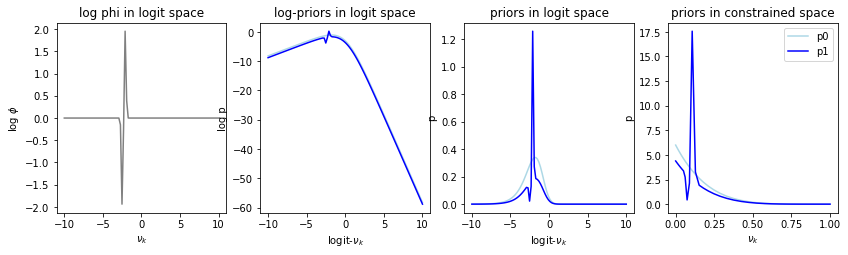

In [38]:
# set up prior perturbation class for plotting
prior_perturbation = func_sens_lib.PriorPerturbation(
                                    alpha0 = alpha0,
                                    log_phi = f_obj.log_phi, 
                                    logit_v_ub = 10, 
                                    logit_v_lb = -10)

prior_perturbation.plot_perturbation()

### overlay prior perturbation with influence function

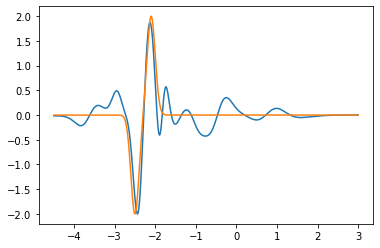

In [39]:
plt.plot(logit_v_grid, influence_grid_x_prior / np.abs(influence_grid_x_prior).max() * 2.0)
plt.plot(logit_v_grid, f_obj.log_phi(logit_v_grid))

# Fit for a range of epsilon

In [40]:
epsilon_vec = [1e-2, 0.5, 1.] 
print(epsilon_vec)

[0.01, 0.5, 1.0]


### Define and pre-compile gradients

So we don't have to recompile for every epsilon ...

In [41]:
def get_loss(vb_params_free, epsilon): 
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    # get perturbation 
    e_log_phi = lambda means, infos : f_obj.e_log_phi_epsilon(means, infos, epsilon)
    
    # now add the dependence on epsilon
    return regression_mixture_lib.get_kl(genome_data, regressors,
                                         vb_params_dict,
                                         prior_params_dict,
                                         gh_loc,
                                         gh_weights, 
                                         e_log_phi = e_log_phi).squeeze()

In [42]:
get_fun = jax.jit(get_loss)

get_grad = jax.jit(jax.grad(get_loss, argnums = 0))

def _get_hvp(x, alpha, v):
    return jax.jvp(jax.grad(get_loss, argnums = 0), (x, alpha), (v, 0.))[1]

get_hvp = jax.jit(_get_hvp)

### Now refit

In [43]:
def refit_with_epsilon(epsilon, new_init_dict):
    
    _, vb_opt_pert, _, optim_time = \
        optimize_kl(lambda x : get_fun(x, epsilon),
                     new_init_dict, 
                     vb_params_paragami, 
                     get_grad = lambda x : get_grad(x, epsilon),
                     get_hvp = lambda x, v: get_hvp(x, epsilon, v),
                     run_lbfgs = False,
                     run_newton = True)                        

    return vb_opt_pert, optim_time

In [44]:
refit_list = []
refit_time_vec = []

new_init_dict = deepcopy(vb_opt_dict)

for epsilon in epsilon_vec: 
    print('\n################')
    print('re-optimzing with epsilon = ', epsilon)
    print('################')
    
    refit_free, optim_time = refit_with_epsilon(epsilon, new_init_dict)
    
    refit_time_vec.append(optim_time)
    refit_list.append(refit_free)
    
    # new_init_dict = deepcopy(vb_params_paragami.fold(refit_free, free = True))


################
re-optimzing with epsilon =  0.01
################
compiling objective and derivatives ... 
done. Compile time: 16.775sec
Running trust-ncg ... 
Newton time: 5.838sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.5
################
compiling objective and derivatives ... 
done. Compile time: 2.091sec
Running trust-ncg ... 
Newton time: 16.883sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  1.0
################
compiling objective and derivatives ... 
done. Compile time: 2.091sec
Running trust-ncg ... 
Newton time: 23.523sec
Newton out:  Optimization terminated successfully.
done. 


### Get linear response for each epsilon

In [45]:
# set sensitivity class
vb_sens._set_cross_hess_and_solve(f_obj.hyper_par_objective_fun)

Compiling cross hessian...
Cross-hessian compile time: 0.466021sec

LR sensitivity time: 2.84213sec



In [46]:
hess_solve_time = vb_sens.lr_time

In [47]:
lr_list = []
lr_time_vec = []

for epsilon in epsilon_vec: 
        
    # get linear response
    t0 = time.time() 
    lr_free_params = vb_sens.predict_opt_par_from_hyper_par(epsilon).block_until_ready()
    elapsed = time.time() - t0
    
    lr_list.append(lr_free_params)
    lr_time_vec.append(elapsed)
    
lr_time_vec = onp.array(lr_time_vec)

In [48]:
lr_time_vec

array([0.04587841, 0.00100636, 0.00095129])

### Print results

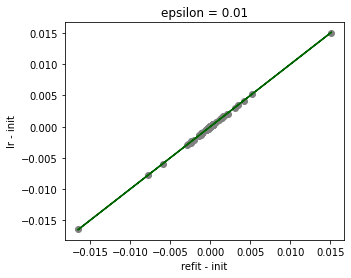

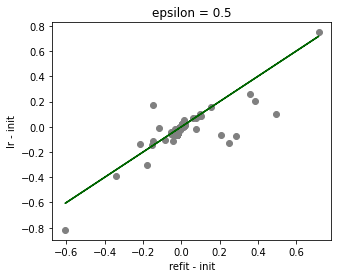

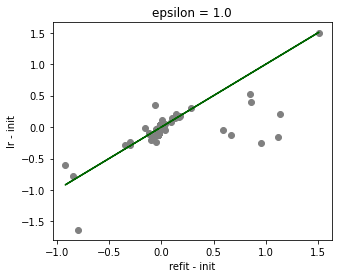

In [49]:
for i in range(len(epsilon_vec)): 
    fig, ax = plt.subplots(1, 1, figsize = (5, 4))

    result_loading_utils.print_diff_plot(refit_list[i], 
                                         lr_list[i],
                                         vb_opt,
                                         ax, 
                                         alpha = 1.)
    
    plt.title('epsilon = {}'.format(epsilon_vec[i]))
    

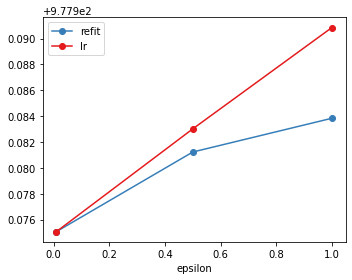

In [50]:
fig, axarr = plt.subplots(1, 1, figsize = (5, 4), sharey = True)

    
result_loading_utils.plot_post_stat_per_epsilon(g,
                                                refit_list,
                                                lr_list,
                                                epsilon_vec, 
                                                axarr)
axarr.legend()
fig.tight_layout();

# Co-clustering

In [51]:
import scipy.cluster.hierarchy as sch

# for better plotting, cluster the ez's
link = sch.linkage(ez_opt, method='average')
perm_obs = sch.dendrogram(link, no_plot=True)["leaves"]

Epsilon =  1.0


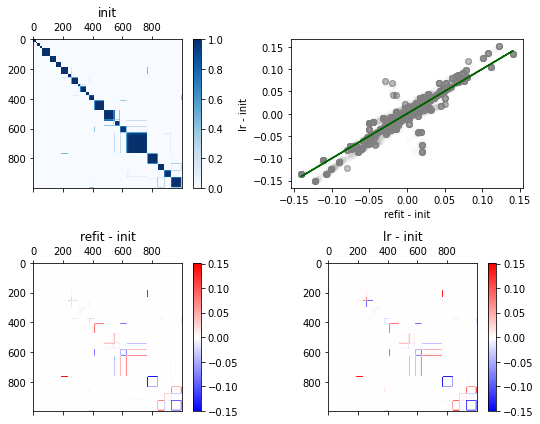

In [52]:
fig, axarr = plt.subplots(2, 2, figsize = (8, 6))

###############
# Compute co-clustering matrices
###############
epsilon_indx = -1
print('Epsilon = ', epsilon_vec[epsilon_indx])

coclust_init = get_coclustering(vb_opt)[perm_obs][:, perm_obs]
coclust_lr = get_coclustering(lr_list[epsilon_indx])[perm_obs][:, perm_obs]
coclust_refit = get_coclustering(refit_list[epsilon_indx])[perm_obs][:, perm_obs]

################
# initial co-clustering matrix
################
im0 = axarr[0, 0].matshow(coclust_init, 
                 cmap = plt.get_cmap('Blues'))
axarr[0, 0].set_title('init')
fig.colorbar(im0, ax = axarr[0, 0])

################
# differences
################
result_loading_utils.print_diff_plot(coclust_refit.flatten(), 
                                    coclust_lr.flatten(),
                                    coclust_init.flatten(), 
                                    axarr[0, 1], 
                                    alpha = 0.01)

result_loading_utils.plot_colormaps(coclust_refit,
                                   coclust_lr,
                                   coclust_init,
                                   fig,
                                   axarr[1], 
                                   plot_initial = False, 
                                   diff_vmax = None)

fig.tight_layout()


In [53]:
if save_data: 
    print('saving into: ')
    outfile = outdata_dir + 'functional_coclustering'
    print(outfile)
    np.savez(outfile, 
         coclust_refit = coclust_refit, 
         coclust_lr = coclust_lr, 
         coclust_init = coclust_init, 
         logit_v_grid = logit_v_grid, 
         log_phi = f_obj.log_phi(logit_v_grid), 
         p0_logit = np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)), 
         pc_logit = np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)), 
         p0_constrained = np.exp(prior_perturbation.get_log_p0(sp.special.expit(logit_v_grid))), 
         pc_constrained = np.exp(prior_perturbation.get_log_pc(sp.special.expit(logit_v_grid))))

saving into: 
/scratch/users/genomic_times_series_bnp/bnp_sensitivity_paper_data/mice/functional_coclustering


In [54]:
if save_data:
    # save timing results
    np.savez(outdata_dir + 'functional_coclustering_timing', 
             grad_time = grad_time, 
             infl_time = infl_time, 
             hess_solve_time = hess_solve_time, 
             refit_time_vec = refit_time_vec, 
             lr_time_vec = lr_time_vec)